### <center> NISQ computing algorithm for solving an n-vertex MaxCut problem with log(N) qubits. </center>

<center> Author : Leder Aguirre </center>
<center> Date : 2023 </center>

### Table of contents

1. [Introduction](#introduction)<br>
2. [Importations](#importations)<br>
3. [Algorithm](#algorithm)
4. [Tests](#tests)
    1. [Optimization using COBYLA](#optimization_COBYLA)
    2. [Optimization using Genetic Algorithms](#optimization_GA)
5. [Bibliography](#bibliography)
$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}
\renewcommand{\bra}[1]{\left\langle{#1}\right|}$

### 1. Introduction <a name="introduction"></a>

#### Problem

For an graph $G=(V,E)$ with edge weights $c_e$, the Max(imum) Cut problem is to find a cut $S \subset V$ such that the weight of edges accross $(S,\bar{S})$ is maximized. It can be formulated as the Quadratic Unconstrained Optimization Problem (QUBO):

Let $y_i$ be the decision variable, equal to 1 if the node $i$ belongs to $S$, 0 otherwise. The optimization problem is:

\begin{align}
\text{max} & \quad & \sum_{(i,j) \in E} w_{i,j} \left(\frac{1 - y_iy_j}{2} \right)\\
\text{s.t.} & \quad & y_i \in \{-1,1\} \quad \forall i \in V
\end{align}


#### Goemans & Williamson approximative algorithm for Max Cut

In the objective function, we replace the $y_i y_j$ by $v_i \cdot v_j$, where $v_i \in {S}_{|V|} \subset \mathbb{R}^{|V|}$ are unitary vectors, $\cdot$ denotes the inner product. Then, we replace each $v_i \cdot v_j$ by the element $p_{i,j}$ of the Gram matrix of the vectors $(v_i)_i$. Therefore, $P = V^T V$, where the columns of $V$ are the column vectors $v_i$. By construction, $P$ is positive semidefinite, so the proposed algorithm follows the following process:

1. Find a symmetric matrix $P = (p_{i,j})_{i,j \in V}$ that is solution to the following optimization problem:  

\begin{align}
    &\text{max} & \quad & \sum_{(i,j) \in E} w_{i,j} \left( \frac{1 - p_{i,j}}{2} \right) \\
    &\text{s.t.} & & p_{i,i} = 1 \: &  \forall i \in V &\\
    & & & x^TPx \geq 0 \: & \forall x \in \mathbb{R}^{|V|} &
\end{align}

where the last infinite set of constraints is handled using a separation oracle. In particular, at each iteration we verify that $P$ has non-negative eigenvalues. If at iteration $k$, $P$ has a negative eigenvalue, we add a constraint of the of the form (3) with $x$ being the eigenvector associated to the negative eigenvalue.

2. Using Cholesky decomposition on $P$, we find a matrix $V$ so that $V^T V = P$.
3. To separate the nodes using the column vectors in $V$, Goemans & Williamson proposed to choose a uniformly random hyperplane ghrough the origin and use it to cut vectors into two parts, as in the image below.

A way to draw a random hyperplane is to pick $r \in \mathbb{R}^{|V|}$, the normal to the hyperplane, randomly from the unit sphere. The partition is done using the formula: $\tilde{y}_i = sgn(r \cdot v_i)$ for each node $i$, where $\tilde{y}_i$ is a particular value for the variable $y_i$ and $sgn(\cdot)$ is the sign function.

#### Performance of the Goemans & Williamson algorithm

Let $S_r$ be the cut associated to the random vector $r \in \mathbb{R}^{|V|}$, $Alg_{GW}(G)$ the expected value of the solution given by this cut (Goemans & Williamson algorithm), $SDP(G)$ the value of the SDP relaxation and $v(G)$ the value of the optimal solution. These value functions satisfy:

\begin{align}
    Alg_{GW}(G) &\coloneqq \mathbb{E}(\text{value of } S_r) = \mathbb{E}\left( \sum_{(i,j) \in E} w_{i,j} \mathbf{1}_{(i,j) \in S_r} \right) = \sum_{(i,j) \in E} w_{i,j} \mathbb{P}\left((i,j) \in S_r\right) = \sum_{(i,j) \in E} w_{i,j} \frac{\arccos(v_i \cdot v_j)}{\pi} \\
    &\geq 0.87854 \sum_{(i,j) \in E} w_{i,j} \frac{1 - p_{i,j}}{2} = 0.87854 \cdot SDP(G) \geq 0.87854 \cdot v(G)
\end{align}

### 2. Importations <a name="importations"></a>

In [13]:
# Imports non Qiskit
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import random

# Imports Qiskit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute,IBMQ
from qiskit.visualization import plot_histogram

from qiskit.circuit.library import Diagonal
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import CircuitStateFn, PauliSumOp
from qiskit.opflow import CircuitSampler, StateFn, AerPauliExpectation, PauliExpectation

from qiskit import Aer
from qiskit.utils import QuantumInstance

# Imports customs
sys.path.append('../code')
#from c_utilities import readGraph, correct_dim
from expectation_functions import R_map, Rf_map, Rfs_map
from expectation_functions import getExpectedValue, parameterizedCircuit, getExpectation
from graph_functions import get_laplacian_matrix
from GW_algorithm import goemans_williamson
from RG_generator import generate_random_graphs

### 3. Toy example <a name="toy_example"></a>

In this section, we will work with a simple instance: a graph with 4 nodes and 3 edges.

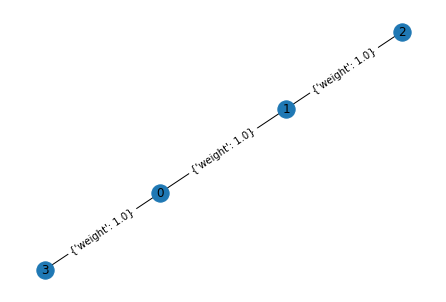

In [2]:
## read the graph
G = nx.readwrite.edgelist.read_weighted_edgelist("../created_data/toy_graph_4.col")    # toy example: 4 nodes, 3 edges

## draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show() 

In [3]:
## defining some useful parameters
num_nodes = G.number_of_nodes()
nodes_labels = [int(node) for node in G.nodes]

## running the random algorithm once

result = goemans_williamson(G)
bound = result[2]
score = result[1]
solution = result[0]
solution_time = result[3]
solution_ord = [solution[x] for _,x in sorted(zip(nodes_labels,list(range(num_nodes))))]
print("SDP bound: ", bound)
print("value of the rounded solution: ", score)
print("solution: ", solution_ord)
print("solution_time: ", solution_time)

SDP bound:  2.9999999783257065
value of the rounded solution:  3.0
solution:  [1.0, -1.0, 1.0, -1.0]
solution_time:  0.04506


### 3. Random instances <a name="toy_example"></a>

In this section we want to measure the performance for a set of random graphs.

In [16]:
# folder Path
path = os.getcwd()
#path = os.path.join(path,"..\\created_data\\random_graphs")
print("current working directory: ", path)
  
# change the directory
os.chdir(path)
  
  
# iterate through all file
root_name = ""
results = []
columns = ["solution", "value", "SDP_bound", "solution_time"]
print(columns)
for file in os.listdir():
    # Check whether file is in text format or not
    if file.endswith(root_name+".col"):
        file_path = f"{path}/{file}"
  
        # read the graph instance
        G = nx.readwrite.edgelist.read_weighted_edgelist(file_path)

        ## defining some useful parameters
        num_nodes = G.number_of_nodes()
        nodes_labels = [int(node) for node in G.nodes]

        ## running the random algorithm once

        result = goemans_williamson(G)
        bound = result[2]
        score = result[1]
        solution = result[0]
        solution_time = result[3]
        solution_ord = [solution[x] for _,x in sorted(zip(nodes_labels,list(range(num_nodes))))]
        result = [solution_ord, score, bound, solution_time]
        results.append(result)
        print(solution, ", ", score, ", ", bound, ", ", solution_time)

current working directory:  d:\Documents\Cycle d'Ingénieur\4A\Stage 4A\Stage UMA\code\Logarithmic-encoding\created_data\random_graphs
['solution', 'value', 'SDP_bound', 'solution_time']
[-1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.] ,  57.0 ,  98.98122383467084 ,  0.31641
[ 1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1.  1. -1.
 -1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.] ,  69.0 ,  93.92837159645673 ,  0.6842
[1. 1. 1. 1.] ,  0.0 ,  -3.2034545016657034e-09 ,  0.03636
[-1. -1. -1. -1. -1.  1. -1. -1.] ,  3.0 ,  6.710174144199888 ,  0.05154


In [17]:
# create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame(results, columns=columns)
df.to_csv("results/GW_algorithm")
df
# saving the results in a .txt file

,solution,value,SDP_bound,solution_time
0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1...",57.0,9.898122e+01,0.31641
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0,...",69.0,9.392837e+01,0.68420
2,"[1.0, 1.0, 1.0, 1.0]",0.0,-3.203455e-09,0.03636
3,"[-1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0]",3.0,6.710174e+00,0.05154
